NYU Center for Data Science

DS-GA 1003 Machine Learning

HW3 - SVMs & Kernel methods

Stephen Spivack (ss7726@nyu.edu)

In [151]:
import os
import time
import random
import numpy as np
import pandas as pd
import itertools
import functools
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,PredefinedSplit, ParameterGrid
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.metrics import mean_squared_error,make_scorer
import scipy.spatial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### 1. Support Vector Machines: SVMs with Pegasos

#### Subgradients

1) Suppose $f_1, ..., f_m:\mathbb{R}^d \rightarrow  \mathbb{R}$ are convex functions, and $f(x) = max_{i=1,...,m} f_i (x)$. Let $k$ be any index for which $f_k(x)$, and choose $g \in \partial f_k(x)$ (a convex function on $\mathbb{R}^d$ has a non-empty subdifferential at all points). Show that $g \in \partial f(x)$.

A vector $g \in \mathbb{R}^d$ is a subgradient of a convex function $f: \mathbb{R}^d \rightarrow \mathbb{R}$ at $x$ if for all $z$, $f(z) \geq f(x) + g^T(z-x)$.

From here we can say that $f(x) = max_{i=1,...,m} f_i(x)$ implies that $f(z) \geq f(x) + g^T(z-x)  = f(x) + g^T(z-x)$.

Therefore, $g \in \partial f(x)$.

2) Give a subgradient of the hinge objective $J(w) = max\{0, 1 - yw^Tx\}$.

$\partial J(w) = 0$ if $yw^Tx \geq 1$

$\partial J(w) = -yx$ if $yw^Tx < 1$

3) Suppose we have a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ which is sub-differentiable everywhere, i.e. $\partial f \neq \emptyset$ for all $x \in \mathbb{R}^n$. Show that $f$ is convex. In general, a function is convex if for all $x,y$ in the domain of $f$ and for all $\theta \in (0,1)$, 

$\theta f(a) + (1 - \theta) f(b) \geq f(\theta a + (1-\theta)(b))$

In [2]:
# XC - TODO

#### SVM with the Pegasos algorithm

4) Consider the SVM objective function for a single training point: $J_i(w) = \frac{\lambda}{2} ||w||^2 + max\{0, 1-y_i w^T x_i \}$. The function $J_i(w)$ is not differentiable everywhere. Specify where the gradient of $J_i(w)$ is not defined. Give an expression for the gradient where it is defined.

$\nabla J_i(w) = \lambda w - y_i x_i$, for $y_i w^T x_i < 1$.

$\nabla J_i(w) = \lambda w$, for $y_i w^T x_i > 1$.

If $y_i w^T x_i = 1$, then $\nabla J_i(w)$ is not defined.

5) Show that a subgradient of $J_i(w)$ is given by

$gw = \lambda w - y_i x_i$, for $y_i w^T x_i < 1$

$gw = \lambda w$, for $y_i w^T x_i \geq 1$

First, we show that $J_i(w)$ is convex:

$J_i(w) = \frac{\lambda}{2} ||w||_2^2 + max(0, 1 - y_i w^T x_i)$

The first term is convex as $\frac{\partial}{\partial w} \frac{\lambda}{2} ||w||_2^2 = \lambda$.

The second term is also convex as $\frac{\partial^2}{\partial^2 w}0=0$ and $\frac{\partial^2}{\partial^2 w}(1 - y_i w^T x_i) = 0$.

Next, if we evaluate $y_i w^T x_i = 1$,

$J_i(w+v) = \frac{\lambda}{2} ||w+v||^2 + max(0, 1 - y_i(w+v)^T x_i)$

$=\frac{\lambda}{2} (||w||^2 + 2w^Tv + ||v||^2) + max(0, 1 - y_i(w+v)^T x_i)$

$=J_i(w) + \lambda w^Tv$,

which implies that $g$ is a subgradient of $J_i(w)$.

#### Dataset and sparse representation

In [4]:
def folder_list(path,label):
    '''
    PARAMETER PATH IS THE PATH OF YOUR LOCAL FOLDER
    '''
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        r.append(label)
        review.append(r)
    return review

def read_data(file):
    '''
    Read each file into a list of strings.
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on',
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    return list(words)

def load_and_shuffle_data():
    '''
    pos_path is where you save positive review data.
    neg_path is where you save negative review data.
    '''
    pos_path = "/Users/stephenspivack/Desktop/NYU/machineLearning/04_supportVectorMachines/hw3/data/pos"
    neg_path = "/Users/stephenspivack/Desktop/NYU/machineLearning/04_supportVectorMachines/hw3/data/neg"

    pos_review = folder_list(pos_path,1)
    neg_review = folder_list(neg_path,-1)

    review = pos_review + neg_review
    random.shuffle(review)
    return review

6) Write a function that converts an example (a list of words) into a sparse bag-of-words representation.

In [5]:
def sparse_bag_of_words(x):
    """
    Input is a list of words for a single training example.
    Output is a sparse bag-of-words representation.
    """
    cnt = Counter()
    for word in x:
        cnt[word] += 1
    return cnt

7) Load all the data and split it into 1500 training examples and 500 validation examples. Format the training data as a list X train of dictionaries and y train as the list of corresponding 1 or -1 labels. Format the test set similarly.

In [6]:
def split_data(review):
    """
    Input is entire dataset. 
    Output is train and test data.
    """
    X = [sparse_bag_of_words(review[i][:-1]) for i in range(len(review))]
    y = [review[i][-1] for i in range(len(review))]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test

In [22]:
review = load_and_shuffle_data()
X_train, X_test, y_train, y_test = split_data(review)

8) Implement the Pegasos algorithm to run on a sparse data representation. The output should be a sparse weight vector $w$ represented as a dictionary. Note that our Pegasos algorithm starts at $w = 0$, which corresponds to an empty dictionary. 

In [8]:
def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v*scale
        
def pegasos_algorithm_v1(X, y, lambda_param, max_epochs):
    """
    Input: X_train, y_train, scalar for lambda parameter, number of training epochs.
    Output: vector w containing weights after max_epochs.
    """
    w, t, epoch = {}, 0, 0
    while epoch < max_epochs:
        for j in range(len(X)):
            t += 1
            eta_t = 1/(t*lambda_param)
            if y[j]*dotProduct(w, X[j]) < 1:
                increment(w, -eta_t*lambda_param, w)
                increment(w, eta_t*y[j], X[j])
            else:
                increment(w, -eta_t*lambda_param, w)
        epoch+=1
    return w

Note that in every step of the Pegasos algorithm, we rescale every entry of $w_t$ by the factor $(1 − \eta_t \lambda)$. Implementing this directly with dictionaries is very slow. We can make things significantly faster by representing $w$ as $w = sW$, where $s \in \mathbb{R}$ and $W \in \mathbb{R}_d$ . You can start with $s = 1$ and $W$ all zeros (i.e. an empty dictionary). Note that both updates (i.e. whether or not we have a margin error) start with rescaling $w_t$, which we can do simply by setting $s_{t+1} = (1 − \eta_t \lambda)s_t$.


9) If the update is $w_{t+1} = (1 - \eta_t \lambda) w_t + \eta_t y_j x_j$, then verify that the Pegasos update step is equivalent to:

$s_{t+1} = (1 - \eta_t \lambda)s_t$

$W_{t+1} = W_t \frac{1}{s_{t+1}} \eta_t y_j x_j$.

$w_{t+1} = s_{t+1}W_{t+1}$

$= (1 - \eta_t \lambda)s_t * (W_t + \frac{1}{s_{t+1}} \eta_t y_j x_j)$

$=(1-\eta_t \lambda)w_t + \eta_t y_j x_j$.

Implement the Pegasos algorithm with the $(s, W)$ representation described above.

In [9]:
def pegasos_algorithm_v2(X, y, lambda_param, max_epochs):
    W, s, t, epoch = {}, 1, 1, 0
    while epoch < max_epochs:
        for j in range(len(X)):
            t += 1
            eta_t = 1/(t*lambda_param)
            s += -eta_t*lambda_param*s
            if y[j]*s*dotProduct(W, X[j]) < 1:
                increment(W, (1/s)*eta_t*y[j], X[j])
        epoch+=1
    W.update((x, s*y) for x, y in W.items())
    return W

10) Run both implementations of Pegasos on the training data for a couple epochs. Make sure your implementations are correct by verifying that the two approaches give essentially the same result. Report on the time taken to run each approach.

In [10]:
start_time = time.time()
w1 = pegasos_algorithm_v1(X_train, y_train, 0.1, 50)
end_time = time.time()
print('Number of seconds to run pegasos_algorithm_v1:', end_time - start_time)
print('First 10 key-value pairs of weights:')
dict(itertools.islice(w1.items(), 10))

Number of seconds to run pegasos_algorithm_v1: 732.7627830505371
First 10 key-value pairs of weights:


{'i': 0.02293333333333321,
 'am': -0.02613333333333317,
 'a': 0.0033333333333331987,
 'steven': 0.011733333333333283,
 'seagal': -0.025199999999999865,
 'fan': -0.008933333333333265,
 'only': -0.14626666666666754,
 'say': -0.012800000000000112,
 'this': -0.054399999999999914,
 'now': 0.011866666666666631}

In [11]:
start_time = time.time()
w2 = pegasos_algorithm_v2(X_train, y_train, 0.1, 50)
end_time = time.time()
print('Number of seconds to run pegasos_algorithm_v2:', end_time - start_time)
print('First 10 key-value pairs of weights:')
dict(itertools.islice(w2.items(), 10))

Number of seconds to run pegasos_algorithm_v2: 6.297619342803955
First 10 key-value pairs of weights:


{'i': 0.020533059559205744,
 'am': -0.024666337782163004,
 'a': -0.0007999893334756519,
 'steven': 0.011999840002133333,
 'seagal': -0.021466380448260762,
 'fan': -0.005999920001066673,
 'only': -0.14999800002666713,
 'say': -0.009466540446127441,
 'this': -0.050665991120118825,
 'now': 0.011733176890974825}

11) Write a function `classification_error` that takes a sparse weight vector $w$, a list of sparse vectors $X$ and the corresponding list of labels $y$, and returns the fraction of errors when predicting $y_i$ using sign$(w^T x_i)$. In other words, the function reports the 0-1 loss of the linear predictor $f(x) = w^T x$.

In [12]:
def classification_error(w, X, y):
    num_errors = 0
    for i in range(len(X)):
        if dotProduct(w, X[i]) < 0:
            pred = -1
        else:
            pred = 1
        if y[i] != pred:
            num_errors += 1
    return num_errors/len(X)

12) Search for the regularization parameter that gives the minimal percent error on your test set. You should now use your faster Pegasos implementation, and run it to convergence. A good search strategy is to start with a set of regularization parameters spanning a broad range of orders of magnitude. Then, continue to zoom in until you’re convinced that additional search will not significantly improve your test performance. Plot the test errors you obtained as a function of the parameters λ you tested. (Hint: the error you get with the best regularization should be closer to $15\%$ than $20\%$. If not, maybe you did not train to convergence.)

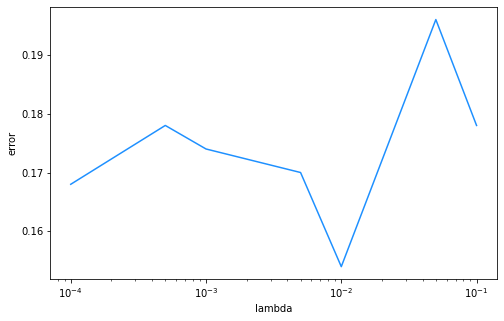

In [23]:
lambda_params = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
losses = [classification_error(pegasos_algorithm_v2(X_train, y_train, lambda_params[i], 100), \
                                                    X_test, y_test) for i in range(len(lambda_params))]
plt.figure(figsize=(8,5))
plt.plot(lambda_params, losses, color='dodgerblue')
plt.xscale('log')
plt.ylabel('error')
plt.xlabel('lambda')
plt.show()

#### Error analysis

13) Break the predictions on the test set into groups based on the score (you can play with the size of the groups to get a result you think is informative). For each group, examine the percentage error. You can make a table or graph. Summarize the results. Is there a correlation between higher magnitude scores and accuracy?

In [ ]:
#XC - TODO

14) Choose an input example $x = (x_1,...,x_d) \in \mathbb{R}^d$ that the model got wrong. We want to investigate what features contributed to this incorrect prediction. One way to rank the importance of the features to the decision is to sort them by the size of their contributions to the score. That is, for each feature we compute $|w_i x_i|$, where $w_i$ is the weight of the $i$th feature in the prediction function, and $x_i$ is the value of the $i$th feature in the input $x$. Create a table of the most important features, sorted by $|w_i x_i|$, including the feature name, the feature value $x_i$, the feature weight $w_i$, and the product $w_i x_i$. Attempt to explain why the model was incorrect. Can you think of a new feature that might be able to fix the issue? Include a short analysis for at least 2 incorrect examples. Can you think of new features that might help fix a problem? (Think of making groups of words.)

In [21]:
#XC - TODO

### 2. Kernel methods

#### Ridge Regression: Theory

Recall the ridge regression objective function:

$J(w) = ||Xw-y||^2 + \lambda||w||^2$, for $\lambda > 0$.

15) Show that for $w$ to be a minimizer of $J(w)$, we must have $X^TXw + \lambda Iw = X^Ty$. Show that the minimizer of $J(w)$ is $w=(X^T X+ \lambda I)^{-1}X^Ty$.

$J(w) = (Xw-y)^T(Xw-y) + \lambda w^Tw$

$\nabla J(w) = 2X^TXw - 2X^Ty + \lambda 2Iw$

$X^TXw + \lambda Iw = X^Ty$

$w = (X^TX) + \lambda I)^{-1} X^T y$

Justify that the matrix $X^T X + \lambda I$ is invertible, for $\lambda > 0$.

Matrix $X^T X + \lambda I$ is positive definite because $u^T(X^TX- \lambda I)u > 0$ and therefore invertible for $\lambda > 0$.

16) Rewrite $X^TXw + \lambda Iwz = X^Ty$ as $w = \frac{1}{\lambda}(X^Ty-X^TXw)$. Based on this, show that $w = X^T\alpha$ for some $\alpha$, and give an expression for $\alpha$.

$w = \frac{1}{\lambda}(X^Ty-X^TXw)$ can be rewritten as $w = X^T \alpha$, where $\alpha = \frac{1}{\lambda}(y-Xw)$.

17) Based on the fact that $w = X^T \alpha$, explain why we say $w$ is "in the span of the data".

Here, $w$ is a linear combination of the data matrix $X$ such that 

$w = \sum_{i=1}^n \alpha_i x_i$, 

therefore $w$ is in the span of $X$.

18) Show that $\alpha = (\lambda I + XX^T)^{-1}y$. Note that $XX^T$ is the kernel matrix for the standard vector dot product.

$\alpha = \frac{1}{\lambda}(y-Xw)$

$\alpha = \frac{1}{\lambda}(y-XX^T\alpha)$

$\lambda I \alpha = y-XX^T\alpha$

$y = \lambda I \alpha + XX^T$

$y = \alpha(\lambda I + XX^T)$

$\alpha = (\lambda I + XX^T)^{-1}y$.

19) Give as kernelized expression for the $Xw$, the predicted values on the training points.

$K = XX^T$

$Xw = XX^T\alpha = XX^T(\lambda I + XX^T)^{-1}y = K(\lambda I + K)^{-1}y$.

20) Give an expression for the prediction $f(x) = x^T w^*$ for a new point $x$, not in the training set.

$f(x) = x^T w^* = xX^T\alpha = k_x\alpha$

#### Kernels and kernel machines

21) Write functions that compute the RBF kernel $k_{RBF(\sigma)}(x,x') = exp(-||x-x'||^2/(2\sigma^2))$ and the polynomial kernel $k_{poly(a,d)}(x,x') = (a+ \langle x,x'\rangle)^d$. Your functions should take as input two matrices $W \in \mathbb{R}^{n_1 \times d}$ and $X \in \mathbb{R}^{n_2 \times d}$ and should return a matrix $M \in \mathbb{R}^{n_1 \times n_2}$ where $M_{ij} = k(W_i, X_j)$. In words, the $(i,j)$'th entry of $M$ should be kernel evaluation between $w_i$ (the $i$th row of $W$) and $x_j$ (the $j$th row of $X$). For the RBF kernel, you may use the scipy function `cdist(X1,X2,'sqeuclidean')` in the package `scipy.spatial.distance`.

In [56]:
def linear_kernel(X1, X2):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
    Returns:
        matrix of size n1xn2, with x1_i^T x2_j in position i,j
    """
    return np.dot(X1,np.transpose(X2))
 
def RBF_kernel(X1, X2, sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||x1_i-x2_j||^2/(2 sigma^2)) in position i,j
    """
    temp = scipy.spatial.distance.cdist(X1, X2, 'sqeuclidean')
    return np.exp(-temp/(2*sigma**2))

def polynomial_kernel(X1, X2, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        X1 - an n1xd matrix with vectors x1_1,...,x1_n1 in the rows
        X2 - an n2xd matrix with vectors x2_1,...,x2_n2 in the rows
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <x1_i,x2_j>)^degree in position i,j
    """
    return (offset + linear_kernel(X1, X2))**degree

22) Use the linear kernel function defined in the code to compute the kernel matrix on the set of points $x_0 \in D_X = \{−4, −1, 0, 2\}$. Include both the code and the output.

In [44]:
x_0 = np.array([-4, -1, 0, 2]).reshape(-1, 1)
linear_kernel(x_0, x_0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

23) Suppose we have the data set $D_{X,y} = \{(−4, 2), (−1, 0), (0, 3), (2, 5)\}$ (in each set of parentheses, the first number is the value of $x_i$ and the second number the corresponding value of the target $y_i$). Then by the representer theorem, the final prediction function will be in the span of the functions $x \rightarrow k(x_0, x)$ for $x_0 \in D_x = \{−4, −1, 0, 2\}$. This set of functions will look quite different depending on the kernel function we use. The set of functions $x \rightarrow k(x_0, x)$ for $x_0 \in X$ and for $x \in [-6,6]$ has been provided for the linear kernel.

(a) Plot the set of functions $x \rightarrow k_{poly(1,3)}(x_0, x)$ for $x_0 \in D_x$ and for $x \in [-6,6]$.

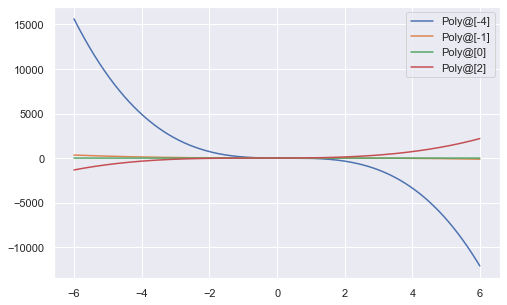

In [89]:
plot_step = 0.01
xpts = np.arange(-6, 6, plot_step).reshape(-1,1) 
x_0 = np.array([-4, -1, 0, 2]).reshape(-1,1)
y = polynomial_kernel(x0, xpts, 1, 3) 
plt.figure(figsize=(8,5))
for i in range(len(x0)):
    plt.plot(xpts, y[i,:], label="Poly@"+str(x_0[i]))
plt.legend()
plt.show()

(b) Plot the set of functions $x \rightarrow k_{RBF(1)}(x_0, x)$ for $x_0 \in X$ and for $x \in [-6,6]$.

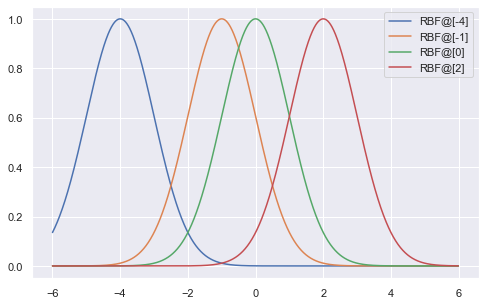

In [90]:
y = RBF_kernel(x0, xpts, 1) 
plt.figure(figsize=(8,5))
for i in range(len(x0)):
    plt.plot(xpts, y[i,:], label="RBF@"+str(x_0[i]))
plt.legend()
plt.show()

24) By the representer theorem, the final prediction function will be of the form $f(x) = \sum_{i=1}^n \alpha_i k(x_i, x)$, where $x_1, ..., x_n \in X$ are the inputs in the training set. We will use the class `Kernel_Machine` in the skeleton code to make prediction with different kernels. Complete the `predict` function of the class `Kernel_Machine`. Construct a `Kernel_Machine` object with the RBF kernel (sigma=1), with prototype points at −1,0,1 and corresponding weights $\alpha_i = \{1, −1, 1\}$. Plot the resulting function.

In [64]:
class Kernel_Machine(object):
    def __init__(self, kernel, training_points, weights):
        """
        Args:
            kernel(X1,X2) - a function return the cross-kernel matrix between rows of X1 and rows of X2 for kernel k
            training_points - an nxd matrix with rows x_1,..., x_n
            weights - a vector of length n with entries alpha_1,...,alpha_n
        """

        self.kernel = kernel
        self.training_points = training_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R alpha_i k(x_j, mu_i)
        """
        k = self.kernel(X, self.training_points)
        return(k@self.weights)

In [74]:
proto_pts = np.array([-1, 0, 1]).reshape(-1,1)
x = np.array([-4, -1, 0, 2]).reshape(-1,1)
alpha = [1, -1, 1]
kernelmachine = Kernel_Machine(functools.partial(RBF_kernel ,sigma=1), proto_pts , alpha)
y_hat = kernelmachine.predict(x)
print(y_hat)

[0.01077726 0.52880462 0.21306132 0.48230437]


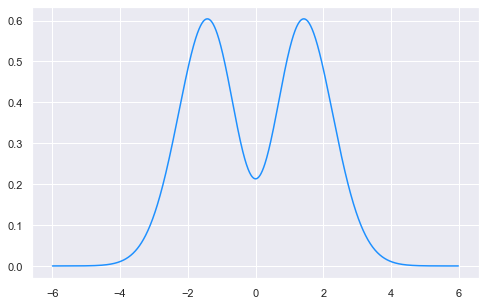

In [88]:
y_hat = kernelmachine.predict(xpts)
plt.figure(figsize=(8,5))
plt.plot(xpts, y_hat, c='dodgerblue')
plt.show()

#### Kernel Ridge Regression

25) Plot the training data. You should note that while there is a clear relationship between $x$ and $y$, the relationship is not linear.

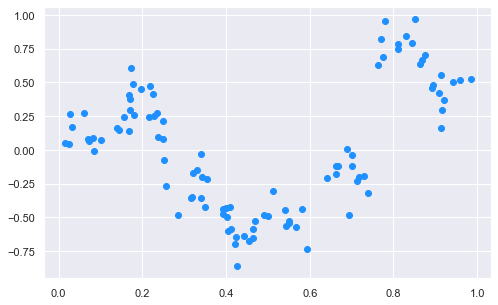

In [128]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)
plt.figure(figsize=(8,5))
plt.plot(x_train, y_train, 'o', c='dodgerblue')
plt.show()

26) In a previous problem, we showed that in kernelized ridge regression, the final prediction function is $f(x) = \sum_{i=1}^n \alpha_i k(x_i, x)$, where $\alpha = (\lambda I +K)^{-1}y$ and $K \in \mathbb{R}^{n \times n}$ is the kernel matrix of the training data: $K_{ij} = k(x_i, x_j)$, for $x_1, ..., x_n$. In terms of kernel machines, $\alpha_i$ is the weight on the kernel function evaluated at the training point $x_i$. Complete the function `train_kernel_ridge_regression` so that it performs kernel ridge regression and returns a `Kernel_Machine` object that can be used for predicting on new points.

In [129]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    K = kernel(X, X)
    alpha = np.linalg.inv(l2reg*np.identity(K.shape[0])+K) @ y
    return Kernel_Machine(kernel, X, alpha)

27) Use the code provided to plot your fits to the training data for the RBF kernel with a fixed regularization parameter of 0.0001 for 3 different values of sigma: 0.01, 0.1, and 1.0. What values of sigma do you think would be more likely to over fit, and which less?

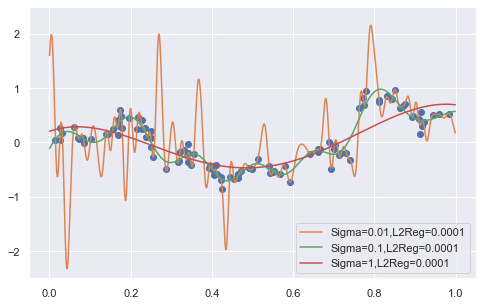

In [130]:
plot_step = 0.001
l2reg = 0.0001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.figure(figsize=(8,5))
plt.plot(x_train,y_train,'o')
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-2.5, 2.5)
plt.show()

Smaller values of sigma tend to overfit.

28) Use the code provided to plot your fits to the training data for the RBF kernel with a fixed sigma of 0.02 and 4 different values of the regularization parameter $\lambda: 0.0001, 0.01, 0.1, 2.0$. What happens to the prediction function as $\lambda \rightarrow$ infinity?

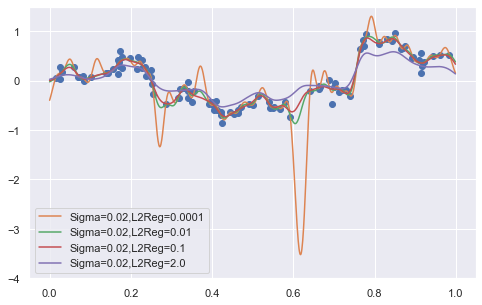

In [131]:
plot_step = 0.001
sigma = 0.02
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.figure(figsize=(8,5))
plt.plot(x_train,y_train,'o')
for l2reg in [0.0001,0.01,0.1,2.0]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-4,1.5)
plt.show()

The prediction function approaches 0 as regularization constant lambda approaches infinity.

29) Find the best hyperparameter settings (including kernel parameters and the regularization parameter) for each of the kernel types. Summarize your results in a table, which gives training error and test error for each setting. Include in your table the best settings for each kernel type, as well as nearby settings that show that making small change in any one of the hyperparameters in either direction will cause the performance to get worse. You should use average square loss on the test set to rank the parameter settings. To make things easier for you, we have provided an sklearn wrapper for the kernel ridge regression function we have created so that you can use sklearn’s GridSearchCV. Note: Because of the small dataset size, these models can be fit extremely fast, so there is no excuse for not doing extensive hyperparameter tuning.

In [138]:
class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return(((self.predict(X)-y)**2).mean()) 

In [152]:
test_fold = [-1]*len(x_train) + [0]*len(x_test)
predefined_split = PredefinedSplit(test_fold=test_fold)

param_grid = [{'kernel': ['RBF'],'sigma':[0.01,0.05,0.1,0.5], 'l2reg': [0.05,0.1,0.5,1]},
              {'kernel':['polynomial'],'offset':[0.1,1,10], 'degree':[5,6,7],'l2reg':[0.001,0.01,0.1] },
              {'kernel':['linear'],'l2reg': [1000,500,100,50,10,5,1,0.5]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False),
                    return_train_score=True
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KernelRidgeRegression(),
             param_grid=[{'kernel': ['RBF'], 'l2reg': [0.05, 0.1, 0.5, 1],
                          'sigma': [0.01, 0.05, 0.1, 0.5]},
                         {'degree': [5, 6, 7], 'kernel': ['polynomial'],
                          'l2reg': [0.001, 0.01, 0.1], 'offset': [0.1, 1, 10]},
                         {'kernel': ['linear'],
                          'l2reg': [1000, 500, 100, 50, 10, 5, 1, 0.5]}],
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [153]:
pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
9,-,RBF,0.50,-,0.05,0.013975,0.014918
5,-,RBF,0.10,-,0.05,0.015176,0.012190
13,-,RBF,1.00,-,0.05,0.015450,0.017943
1,-,RBF,0.05,-,0.05,0.016193,0.011565
0,-,RBF,0.05,-,0.01,0.018616,0.004931
...,...,...,...,...,...,...,...
47,-,linear,10.00,-,-,0.164591,0.206780
46,-,linear,50.00,-,-,0.165678,0.208251
45,-,linear,100.00,-,-,0.166435,0.209156
44,-,linear,500.00,-,-,0.167602,0.210499


30) Plot your best fitting prediction functions using the polynomial kernel and the RBF kernel. Use the domain $x \in (−0.5, 1.5)$. Comment on the results.

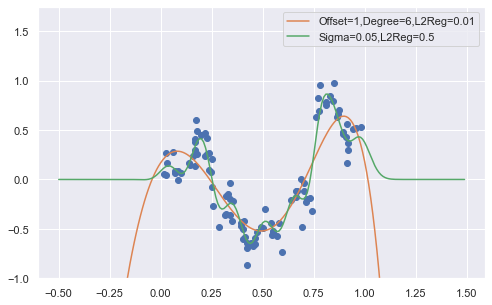

In [155]:
## Plot the best polynomial and RBF fits you found
plt.figure(figsize=(8,5))
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= 1
degree = 6
l2reg = 0.01
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = 0.05
l2reg= 0.5
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)
plt.show()

31) The data for this problem was generated as follows: A function $f : \mathbb{R} \rightarrow \mathbb{R}$
was chosen. Then to generate a point $(x,y)$, we sampled $x$ uniformly from $(0,1)$ and we
sampled $\epsilon ~ N(0,0.1)^2$ (so $var(\epsilon) = 0.12$). The final point is $(x,f(x)+\epsilon)$. What is the Bayes decision function and the Bayes risk for the loss function $\ell (\hat{y}, y) = (\hat{y} − y)$?

Bayes decision function $E(y|x) = E(f(x)+\epsilon|x) = f(x)$.

Bayesian risk $E((F(x)-y)^2) = E(f(x)-f(x)-\epsilon)^2 = 0.1^2$.

### 3. Kernel SVMs with Kernelized Pegasos

32) Load the SVM training `svm-train.txt` and `svm-test.txt` test data from the zip file. Plot the training data using the code supplied. Are the data linearly separable? Quadratically separable? What if we used some RBF kernel?

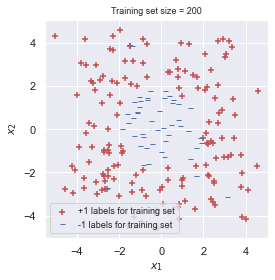

In [159]:
# Load and plot the SVM data
#load the training and test sets
data_train,data_test = np.loadtxt("svm-train.txt"),np.loadtxt("svm-test.txt")
x_train, y_train = data_train[:,0:2], data_train[:,2].reshape(-1,1)
x_test, y_test = data_test[:,0:2], data_test[:,2].reshape(-1,1)

#determine predictions for the training set
yplus = np.ma.masked_where(y_train[:,0]<=0, y_train[:,0])
xplus = x_train[~np.array(yplus.mask)]
yminus = np.ma.masked_where(y_train[:,0]>0, y_train[:,0])
xminus = x_train[~np.array(yminus.mask)]

#plot the predictions for the training set
figsize = plt.figaspect(1)
f, (ax) = plt.subplots(1, 1, figsize=figsize) 

pluses = ax.scatter (xplus[:,0], xplus[:,1], marker='+', c='r', label = '+1 labels for training set')
minuses = ax.scatter (xminus[:,0], xminus[:,1], marker=r'$-$', c='b', label = '-1 labels for training set')

ax.set_ylabel(r"$x_2$", fontsize=11)
ax.set_xlabel(r"$x_1$", fontsize=11)
ax.set_title('Training set size = %s'% len(data_train), fontsize=9)  
ax.axis('tight')
ax.legend(handles=[pluses, minuses], fontsize=9)
plt.show()

33) Unlike for kernel ridge regression, there is no closed-form solution for SVM classification (kernelized or not). Implement kernelized Pegasos. Because we are not using a sparse representation for this data, you will probably not see much gain by implementing the “optimized” versions described in the problems above.

In [161]:
# XC - TODO

34) Find the best hyperparameter settings (including kernel parameters and the regularization parameter) for each of the kernel types. Summarize your results in a table, which gives training error and test error (i.e. average 0/1 loss) for each setting. Include in your table the best settings for each kernel type, as well as nearby settings that show that making small change in any one of the hyperparameters in either direction will cause the performance to get worse. You should use the 0/1 loss on the test set to rank the parameter settings.


In [160]:
# XC - TODO

35) Plot your best fitting prediction functions using the linear, polynomial, and the RBF kernel. The code provided may help.

In [ ]:
# XC - TODO